# **Modélisation par avec un machine à vecteurs de supports (SVR)**

[SVR]: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

[NuSVR]: https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVR.html

[LinearSVR]: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html

**API SKL** : [**`SVR`**][SVR], [**`LinearSVR`**][LinearSVR], [**`NuSVR`**][NuSVR]

**Guide SKL** : [**Support Vector Machines** (1.4)](https://scikit-learn.org/stable/modules/svm.html)

**Résout** :
* Le primal :

$\begin{align}\begin{aligned}
    \min_ {w, b, \zeta, \zeta^*} \frac{1}{2} w^\top w +
    C \sum_{i=1}^{n} (\zeta_i + \zeta_i^*)\\
    \begin{split}\textrm {sous la contrainte de } & y_i - w^\top \phi (x_i) - b \leq \varepsilon + \zeta_i,\\
        & w^\top \phi (x_i) + b - y_i \leq \varepsilon + \zeta_i^*,\\
        & \zeta_i, \zeta_i^* \geq 0, i=1, ..., n\end{split}
\end{aligned}\end{align}$

* Le dual :
$\begin{align}\begin{aligned}
    \min_{\alpha, \alpha^*} \frac{1}{2} (\alpha - \alpha^*)^\top Q (\alpha - \alpha^*) +
    \varepsilon e^\top (\alpha + \alpha^*) - y^\top (\alpha - \alpha^*)\\
    \begin{split}
        \textrm {sous la contrainte de } & e^\top (\alpha - \alpha^*) = 0\\
        & 0 \leq \alpha_i, \alpha_i^* \leq C, i=1, ..., n
    \end{split}
\end{aligned}\end{align}$

* Primal décliné pour la LinearSVR :

$$\displaystyle\min_ {w, b} \displaystyle\frac{1}{2} w^\top w + C \displaystyle\sum_{i=1}\max(0, |y_i - (w^\top \phi(x_i) + b)| - \varepsilon),$$


**Complexité** :
* Implémentation générique basée sur [libsvm](https://www.csie.ntu.edu.tw/~cjlin/libsvm/) : évolue entre $\mathcal{O}(p \times n^2)$ et $\mathcal{O}(p \times n^3)$
* Implémentation spécialisée noyau linéaire basée sur [liblinear](https://www.csie.ntu.edu.tw/~cjlin/liblinear/) : $\mathcal{O}(n)$

## Chargement et nettoyage des données

In [1]:
from pepper_commons import get_data
from seattle_commons import clean_dataset, drop_my_outliers
data = get_data()                                    # load data from CSV file
data, not_compliant, outliers = clean_dataset(data)  # drop outliers identified by Seattle
data, my_outliers = drop_my_outliers(data)           # drop my own outliers (18)

✔ _data loaded
✔ struct loaded


## Partition *résidentiel* vs. *non résidentiel*

In [2]:
from seattle_commons import get_family_buildings, get_business_buildings
r_data = get_family_buildings(data)                # residential subset
nr_data = get_business_buildings(data)             # non residential subset

# Expérimentation

## Config 9 : $\ln{e} = f(\ln{a}, n_\star)$

Contribution du score ENERGYSTAR.

$\{n_\star, \log(a) :\log(e)\}$

Amélioration négligeable.

$R^2_{9, \text{LASSO}}$:
* $\mu = 0.6166563538370583$
* $\sigma = 0.05979515734612156$

$R^2_{9, \text{Ridge}}$:
* $\mu = 0.6166516138510613$
* $\sigma = 0.0599534988115941$

$R^2_{9, \text{OLS}}$:
* $\mu = 0.616668067176413$
* $\sigma = 0.059980161457964365$

$R^2_{\text{OLS}, 4} \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [3]:
config_name = "{n_★, log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

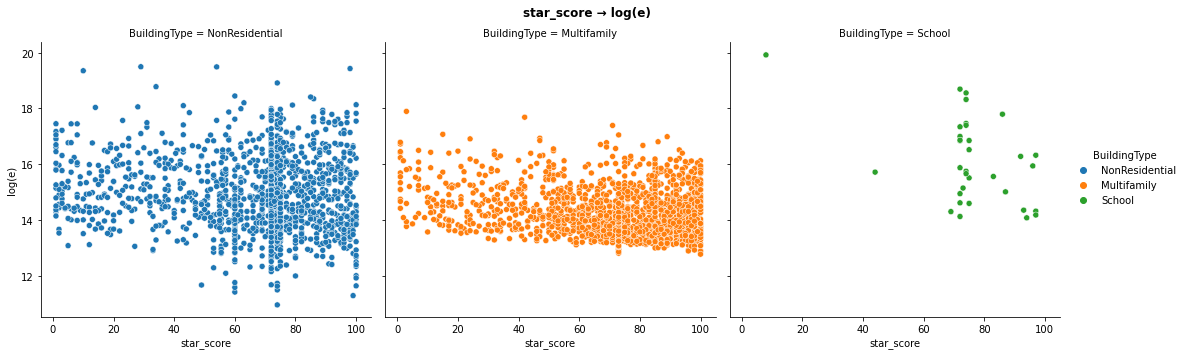

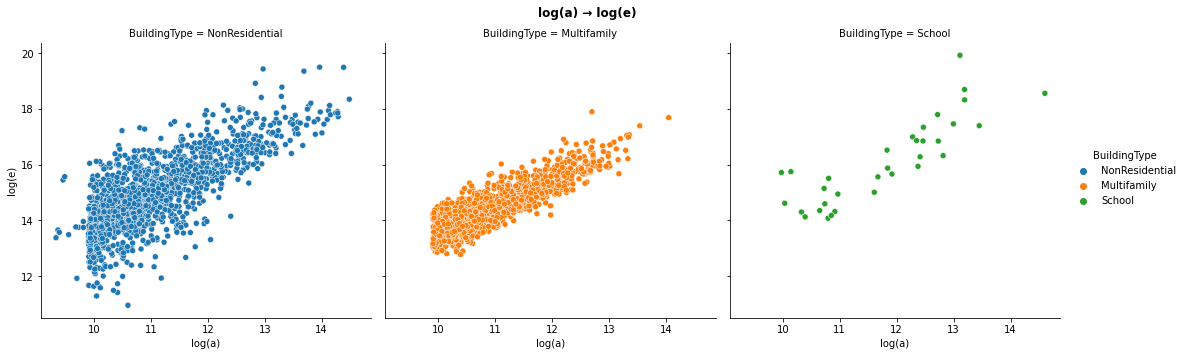

In [4]:
# title="star_score = ENERGYSTARScore → log(e = SiteEnergyUse(kBtu))"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [5]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [4]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Entraînement et performances

##### Recherche en grille externe SVR

Première exécution sur grille à 10 configurations : ... minutes ... secondes

In [6]:
from pepper_skl_commons import get_lr_baseline_err
from pepper_commons import bold
baseline_err = get_lr_baseline_err(X_train, y_train)
print(bold('LR r2'), ':', baseline_err)

LR r2 : 0.6971301496397384


In [7]:
import numpy as np
import pandas as pd
from sklearn import svm
from pepper_skl_commons import get_best_params

Xy = X_train, X_test, y_train, y_test
model = svm.SVR()
min_alpha_log = -1
max_alpha_log = 2
n_alphas = 10

param_grid = {
    'kernel': ['linear'],
    'C': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'gamma': ['auto'],
    'epsilon': [.1],
}

gbp_res = (
    best_estimator, best_params, best_score, best_index, scorer, cv_res
) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

coucou

In [ ]:
from pepper_skl_commons import show_best_params
show_best_params(gbp_res, Xy, X, y)


Best
best estimator : Lasso(alpha=0.006135907273413176, max_iter=100000, random_state=42)
best params : {'alpha': 0.006135907273413176, 'max_iter': 100000, 'positive': False, 'random_state': 42}
best score : 0.697175907571976
best index : 93

Scores
    train score : 0.7062291136011234
     test score : 0.6784833957465781
3-CV mean score : 0.616076531978844
 3-CV std score : 0.058378371992854304


##### Recherche en grille externe LinearSVR

In [ ]:
from pepper_skl_commons import get_lr_baseline_err
from pepper_commons import bold
baseline_err = get_lr_baseline_err(X_train, y_train)
print(bold('LR r2'), ':', baseline_err)

LR r2 : 0.6971301496397384


In [ ]:
import numpy as np
import pandas as pd
from sklearn import svm
from pepper_skl_commons import get_best_params

Xy = X_train, X_test, y_train, y_test

svr_base_params = {
    'dual': False,              # because n >> p
    'random_state': 42,
}

model = svm.LinearSVR(**svr_base_params)

min_alpha_log = -1
max_alpha_log = 2
n_alphas = 10

param_grid = {
    'C': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'epsilon': [.1],
}

gbp_res = (
    best_estimator, best_params, best_score, best_index, scorer, cv_res
) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

coucou

In [ ]:
from pepper_skl_commons import show_best_params
show_best_params(gbp_res, Xy, X, y)


Best
best estimator : Lasso(alpha=0.006135907273413176, max_iter=100000, random_state=42)
best params : {'alpha': 0.006135907273413176, 'max_iter': 100000, 'positive': False, 'random_state': 42}
best score : 0.697175907571976
best index : 93

Scores
    train score : 0.7062291136011234
     test score : 0.6784833957465781
3-CV mean score : 0.616076531978844
 3-CV std score : 0.058378371992854304
